In [29]:
!pip install tensorflow numpy matplotlib



In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image
import os


In [5]:
# Load and preprocess images
def load_and_process_img(path):
    img = load_img(path, target_size=(400, 400))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return vgg19.preprocess_input(img)


In [7]:
# Deprocess image for viewing
def deprocess_img(img):
    img = img.reshape((400, 400, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]  # BGR to RGB
    return np.clip(img, 0, 255).astype('uint8')


In [9]:
# Compute content loss
def compute_content_loss(base, target):
    return tf.reduce_mean(tf.square(base - target))

In [11]:
# Compute Gram matrix for style representation
def gram_matrix(tensor):
    channels = int(tensor.shape[-1])
    a = tf.reshape(tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

In [13]:
# Compute style loss
def compute_style_loss(base_style, gram_target):
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))

In [15]:
# Load VGG19 and select layers
def get_model():
    vgg = vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1']
    content_layer = 'block5_conv2'
    outputs = [vgg.get_layer(name).output for name in style_layers + [content_layer]]
    return Model(inputs=vgg.input, outputs=outputs), style_layers, content_layer


In [17]:
# Extract features
def get_features(model, image, num_style_layers):
    outputs = model(image)
    style_features = outputs[:num_style_layers]
    content_feature = outputs[-1]
    return style_features, content_feature

In [25]:
# Main style transfer function
def style_transfer(content_path, style_path, iterations=100, style_weight=1e4, content_weight=1e0):
    model, style_layers, content_layer = get_model()
    num_style_layers = len(style_layers)

    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)
    generated_image = tf.Variable(content_image, dtype=tf.float32)

    style_features, _ = get_features(model, style_image, num_style_layers)
    _, content_feature = get_features(model, content_image, num_style_layers)

    gram_style_features = [gram_matrix(style) for style in style_features]
    optimizer = tf.optimizers.Adam(learning_rate=5.0)

    @tf.function()
    def train_step():
        with tf.GradientTape() as tape:
            style_output, content_output = get_features(model, generated_image, num_style_layers)
            style_loss = tf.add_n([compute_style_loss(style_output[i], gram_style_features[i])
                                   for i in range(num_style_layers)])
            style_loss *= style_weight / num_style_layers

            content_loss = compute_content_loss(content_output, content_feature)
            content_loss *= content_weight

            total_loss = style_loss + content_loss

        grad = tape.gradient(total_loss, generated_image)
        optimizer.apply_gradients([(grad, generated_image)])
        generated_image.assign(tf.clip_by_value(generated_image, -103.939, 255.0 - 103.939))
        return total_loss

    for i in range(iterations):
        loss = train_step()
        if i % 10 == 0:
            print(f"Iteration {i}: Loss = {loss.numpy()}")

    final_img = deprocess_img(generated_image.numpy())
    Image.fromarray(final_img).save("output.jpg")
    print("Saved styled image as output.jpg")
    return final_img


2025-06-08 20:14:57.425014: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


Iteration 0: Loss = 1114536804352.0
Iteration 10: Loss = 658177064960.0
Iteration 20: Loss = 531436830720.0
Iteration 30: Loss = 451824943104.0
Iteration 40: Loss = 395668750336.0
Iteration 50: Loss = 352585383936.0
Iteration 60: Loss = 316417802240.0
Iteration 70: Loss = 284650766336.0
Iteration 80: Loss = 256735772672.0
Iteration 90: Loss = 232693891072.0
Saved styled image as output.jpg


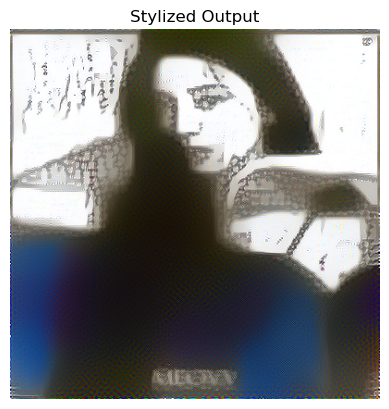

In [33]:
# Run style transfer
if __name__ == "__main__":
    content_image_path = "content.jpg"
    style_image_path = "style.jpg"

    if not os.path.exists(content_image_path) or not os.path.exists(style_image_path):
        print("Please make sure 'content.jpg' and 'style.jpg' exist in the project folder.")
    else:
        styled_image = style_transfer(content_image_path, style_image_path, iterations=100)
        plt.imshow(styled_image)
        plt.axis('off')
        plt.title("Stylized Output")
        plt.show()
